In [1]:
import pandas as pd
from configurator import Config
from matplotlib.pyplot import gca, subplot, figure
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter
from common import root_from

In [2]:
config = Config.from_path('config.yaml')
root = root_from(config)

In [77]:
def lines(ax):
    for value in 3.5, 7.4:
        ax.axhline(y=value, color='grey', linestyle='dotted', label=f'{value}kW')

In [92]:
def plot_tesla_range(start: str, end: str, ax=None, title='', abs: bool = False, net_only: bool=True):
    # Force start/end to UTC tz-aware
    start = pd.Timestamp(start, tz="UTC")
    end = pd.Timestamp(end, tz="UTC")
    if end < start:
        raise ValueError("end must be after start")

    # Collect all daily files and blow up early if any missing
    days = pd.date_range(start.normalize(), end.normalize(), freq="D", tz="UTC")
    paths = [root / d.strftime("tesla-%Y-%m-%d.csv") for d in days]
    missing = [p for p in paths if not p.exists()]
    if missing:
        raise FileNotFoundError(f"Missing daily CSVs: {', '.join(str(p) for p in missing)}")

    # Read and normalise to UTC
    frames = []
    for p in paths:
        df = pd.read_csv(p, index_col="timestamp", parse_dates=[0])
        df.index = pd.to_datetime(df.index, utc=True)  # force UTC tz-aware
        frames.append(df)

    # Combine and slice
    data = pd.concat(frames).sort_index()
    data = data[(data.index >= start) & (data.index <= end)]
    if data.empty:
        raise ValueError("No data points within the requested range")

    # Plot
    ax = ax or gca()
    full_title = f"Tesla: {start:%a %d %b %Y %H:%M} to {end:%a %d %b %Y %H:%M}"
    if title:
        full_title = f'{full_title} - {title}'
    ax.set_title(full_title)
    lines(ax)

    tesla_kw = data / 1000.0
    tesla_kw = tesla_kw.loc[:, (tesla_kw != 0).any()]
    if abs:
        tesla_kw = tesla_kw.abs().rename(columns=lambda name: f"abs({name})")

    if not net_only:
        for col in tesla_kw.columns:
            ax.plot(tesla_kw.index, tesla_kw[col], label=col)
    ax.plot(tesla_kw.index, tesla_kw.sum(axis=1), label='net usage', linestyle=':', color='red')

    ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
    ax.legend()

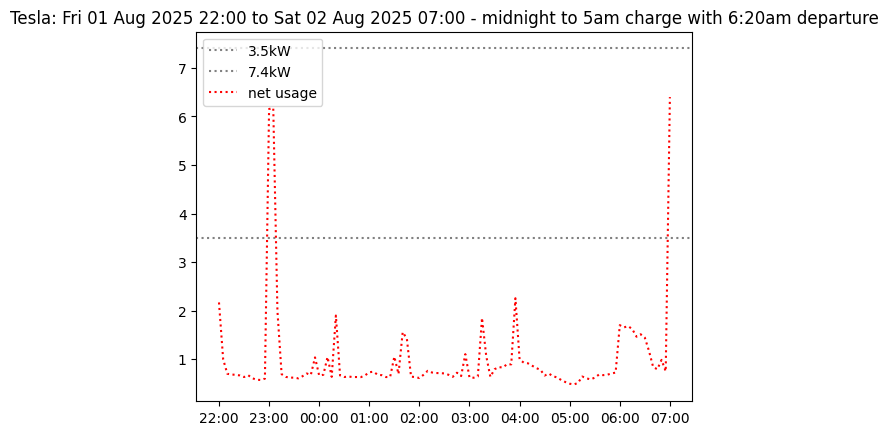

In [93]:
plot_tesla_range(start='2025-08-01 22:00', end='2025-08-02 07:00', title='midnight to 5am charge with 6:20am departure')

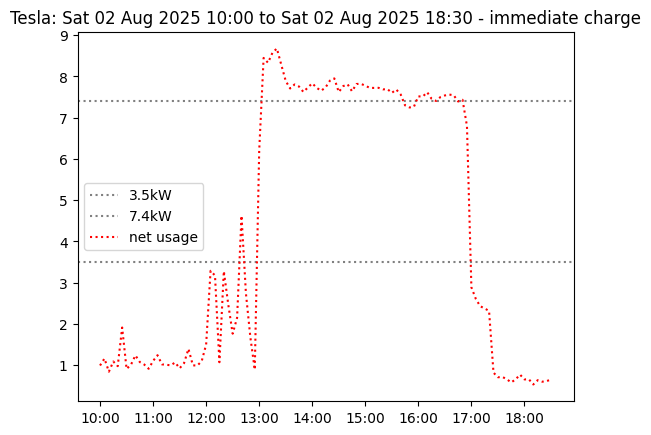

In [94]:
plot_tesla_range(start='2025-08-02 10:00', end='2025-08-02 18:30', title='immediate charge')

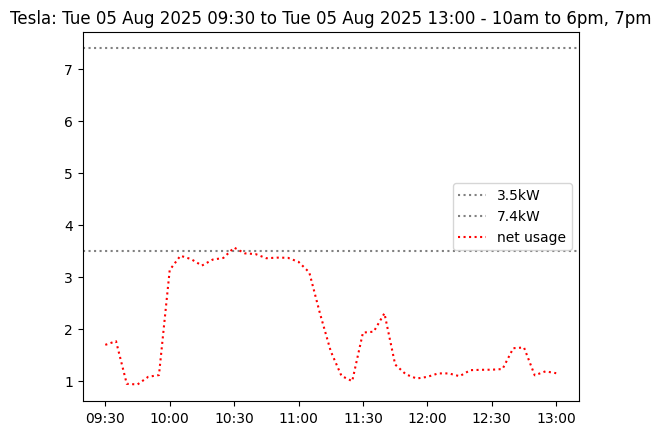

In [95]:
plot_tesla_range(start='2025-08-05 09:30', end='2025-08-05 13:00', title='10am to 6pm, 7pm')

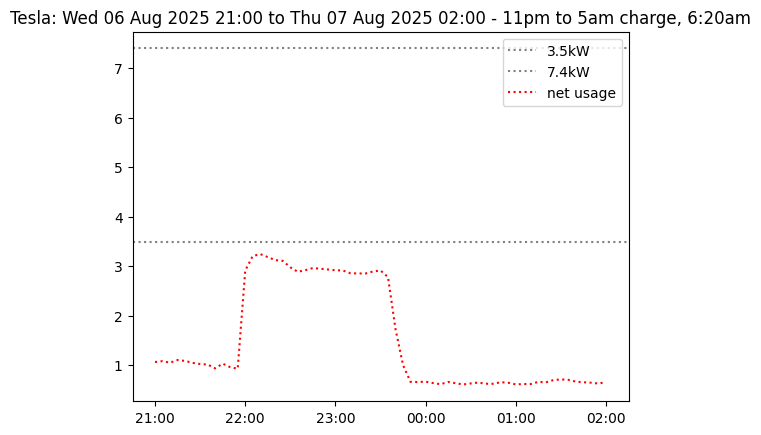

In [97]:
plot_tesla_range(start='2025-08-06 21:00', end='2025-08-07 02:00', title='11pm to 5am charge, 6:20am')

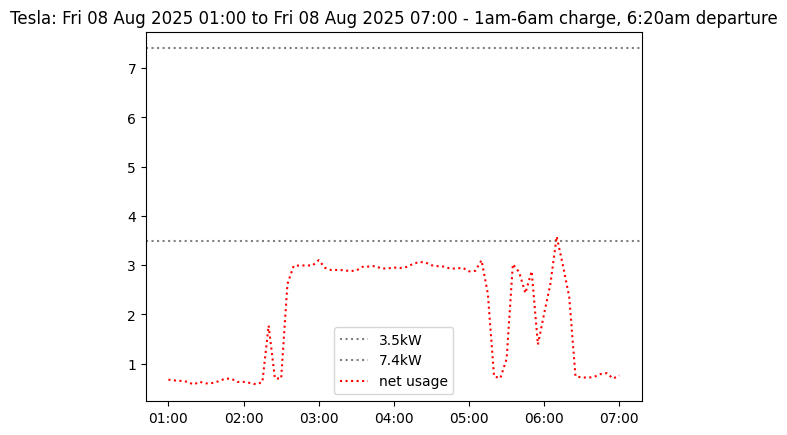

In [98]:
plot_tesla_range(start='2025-08-08 01:00', end='2025-08-08 07:00', title='1am-6am charge, 6:20am departure')